# Band Importance

The goal of the first experiment is to find the best combination of bands, which consist of Sentinel 2 Level-2A bands and derived indices for our problem. The experiment assumes the following:

- A composite raster is created from a 1 year long time window, starting with 1. April, 2017, thus covering all seasons. April of 2017 was the first whole month with Level-2A imagery and the closest to the recording dates.
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

The experiment is conducted on all Level-2A bands accessible from Google Earth Engine as well as all indices offered by the [eemont](https://github.com/davemlz/eemont) package:

In [3]:
# List all available Sentinel 2 Level-2A bands
from ltm.data import list_bands

bands = list_bands()

bands

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL',
 'TCI_R',
 'TCI_G',
 'TCI_B',
 'MSK_CLDPRB',
 'MSK_SNWPRB',
 'QA10',
 'QA20',
 'QA60',
 'MSK_CLASSI_OPAQUE',
 'MSK_CLASSI_CIRRUS',
 'MSK_CLASSI_SNOW_ICE']

In [4]:
# List all available indices offered by eemont
from ltm.data import list_indices

indices = list_indices()

indices

['AFRI1600',
 'AFRI2100',
 'ANDWI',
 'ARI',
 'ARI2',
 'ARVI',
 'ATSAVI',
 'AVI',
 'AWEInsh',
 'AWEIsh',
 'BAI',
 'BAIM',
 'BAIS2',
 'BCC',
 'BI',
 'BITM',
 'BIXS',
 'BLFEI',
 'BNDVI',
 'BRBA',
 'BWDRVI',
 'BaI',
 'CIG',
 'CIRE',
 'CSI',
 'CVI',
 'DBSI',
 'DSI',
 'DSWI1',
 'DSWI2',
 'DSWI3',
 'DSWI4',
 'DSWI5',
 'DVI',
 'DVIplus',
 'EMBI',
 'EVI',
 'EVI2',
 'ExG',
 'ExGR',
 'ExR',
 'FCVI',
 'GARI',
 'GBNDVI',
 'GCC',
 'GDVI',
 'GEMI',
 'GLI',
 'GM1',
 'GM2',
 'GNDVI',
 'GOSAVI',
 'GRNDVI',
 'GRVI',
 'GSAVI',
 'GVMI',
 'IAVI',
 'IBI',
 'IKAW',
 'IPVI',
 'IRECI',
 'LSWI',
 'MBI',
 'MBWI',
 'MCARI',
 'MCARI1',
 'MCARI2',
 'MCARI705',
 'MCARIOSAVI',
 'MCARIOSAVI705',
 'MGRVI',
 'MIRBI',
 'MLSWI26',
 'MLSWI27',
 'MNDVI',
 'MNDWI',
 'MNLI',
 'MRBVI',
 'MSAVI',
 'MSI',
 'MSR',
 'MSR705',
 'MTCI',
 'MTVI1',
 'MTVI2',
 'MuWIR',
 'NBAI',
 'NBR',
 'NBR2',
 'NBRSWIR',
 'NBRplus',
 'NBSIMS',
 'ND705',
 'NDBI',
 'NDCI',
 'NDDI',
 'NDGI',
 'NDGlaI',
 'NDII',
 'NDMI',
 'NDPI',
 'NDPonI',
 'NDREI',
 'ND

In [1]:
# Create a composite from a Sentinel image with all available bands and indices
from ltm.data import sentinel_composite
from datetime import datetime
from pathlib import Path

# Define the label path as well as the path to write the raster to
y_path = "../data/processed/y.tif"
X_path = "../data/processed/band_importance/X_sentinel.tif"

# Create the composite if it does not exist
if not Path(X_path).exists():
    sentinel_composite(
        y_path_from=y_path,
        X_path_to=X_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
        indices=indices,
        sentinel_bands=bands,
    )

In [2]:
# Use science style for plots
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

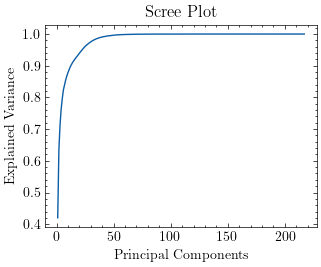

In [3]:
# Draw the scree plot for X_sentinel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from ltm.features import load_raster
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the dataset
X = load_raster("../data/processed/band_importance/X_sentinel.tif")
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Define PCA model to use
pca = PCA()
pca_fit = pca.fit(scaled_df)
PC_values = np.arange(pca.n_components_) + 1

# Plot
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_))
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.show()

In [4]:
# Compute the scores for each step of the RFE for PALSAR and Sentinel data
from ltm.data import split_band_name
from ltm.features import load_raster, drop_nan_rows
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate

import pandas as pd
from tqdm import tqdm

# Check if the report is already available
band_importance_path = "../reports/band_importance.csv"
if not Path(band_importance_path).exists():
    # Load the raster, label and drop rows with NaN values
    X = load_raster(X_path)
    y = load_raster(y_path)
    X, y = drop_nan_rows(X, y)

    # Create the RFE object and rank each pixel
    rf = RandomForestRegressor(n_jobs=-1)
    rfe = RFE(estimator=rf, n_features_to_select=1, step=1, verbose=1)
    rfe.fit(X, y)

    # Define the scoring metrics
    scoring = {
        "R2 Score": make_scorer(r2_score),
        "Mean Absolute Error": make_scorer(mean_absolute_error),
        "Root Mean Squared Error": make_scorer(mean_squared_error, squared=False)
    }

    # Get the features in reverse order of elimination
    ranking = rfe.ranking_
    feature_names = rfe.feature_names_in_
    order_index = ranking.argsort()
    ordered_features = feature_names[order_index]

    # Compute the scores for each step of the RFE
    score_df = pd.DataFrame(columns=scoring.keys())
    for i in tqdm(range(ordered_features.shape[0])):
        # Fit the model with the current features
        curr_X = X[ordered_features[:i+1]]
        random_forest = RandomForestRegressor(n_jobs=-1, random_state=42)
        scores = cross_validate(random_forest, curr_X, y, scoring=scoring, n_jobs=-1)

        # Store the scores in the dataframe
        reducer_name = split_band_name(ordered_features[i])[2]
        score_df.loc[reducer_name] = [scores[f"test_{key}"].mean() for key in scoring.keys()]

    # Save the scores to a CSV file
    score_df.to_csv(band_importance_path, index_label="Band")
    score_df.index.name = "Band"
else:
    # Load the scores from the CSV file
    score_df = pd.read_csv(band_importance_path, index_col=0)

score_df

,R2 Score,Mean Absolute Error,Root Mean Squared Error
Band,,,
NDGI,0.373424,0.217894,0.353133
kIPVI,0.485302,0.211314,0.319989
MIRBI,0.532511,0.199066,0.305205
BWDRVI,0.542340,0.199121,0.301982
MNLI,0.573109,0.193284,0.291747
...,...,...,...
MSK CLDPRB,0.592502,0.196973,0.284721
QA20,0.592000,0.197563,0.284886
MSK SNWPRB,0.591904,0.197250,0.284888


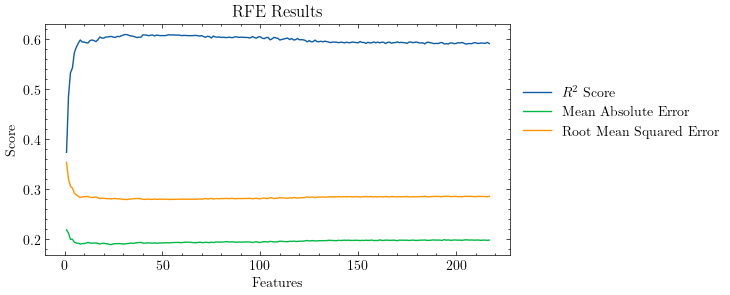

In [5]:
# Plot the RFE results
from ltm.models import plot_report

# Replace the index with number of features
df = score_df.reset_index()
df.index = df.index + 1

# Plot
ax = plot_report(
    df,
    "RFE Results",
    "Features",
    "Score",
    label_rotation=90,
    replace_labels={"R2 Score": "$R^2$ Score"},
    figsize=(6, 3),
    categorical_x=False,
)

plt.show()

In [1]:
# List all bands up to the last band with an optimal score
from ltm.models import bands_from_importance

sentinel_bands, index_bands = bands_from_importance("../reports/band_importance.csv")

sentinel_bands, index_bands

Initializing Earth Engine API...


(['B9', 'WVP', 'TCI_G'],
 ['BAIM',
  'BCC',
  'BRBA',
  'BWDRVI',
  'GCC',
  'GVMI',
  'MCARI705',
  'MGRVI',
  'MIRBI',
  'MLSWI26',
  'MNLI',
  'MTCI',
  'NBRplus',
  'NDCI',
  'NDDI',
  'NDGI',
  'S2WI',
  'SIPI',
  'TRRVI',
  'TTVI',
  'VIBI',
  'WI2015',
  'kEVI',
  'kIPVI',
  'kNDVI',
  'kVARI',
  'mND705',
  'mSR705'])